In [1]:
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp

In [2]:
import os




In [3]:

os.chdir(os.path.dirname('/home/hackerman/GitHub/exploration/tf_fun/'))

# propriatary mnist management
DATASETSLIB_HOME = './datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

/home/hackerman/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import pandas as pd
import numpy as np
filename = os.path.join(datasetslib.datasets_root,'international-airline-passengers.csv')
dataframe = pd.read_csv(filename,usecols=[1],header=0)
dataset = dataframe.values
dataset = dataset.astype(np.float32)

scaler = pp.MinMaxScaler(feature_range=(0,1))
normalized_dataset = scaler.fit_transform(dataset)

train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)

n_x=1
n_y=1
X_train, Y_train, X_test, Y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=n_y)

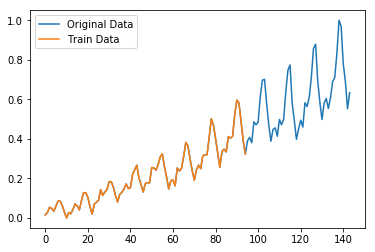

In [5]:
plt.plot(normalized_dataset,label='Original Data')
plt.plot(X_train,label='Train Data')
plt.legend()
plt.show()

In [6]:
state_size = 32
n_epochs = 2000
n_timesteps = n_x
learning_rate = 0.1
n_x_vars = 1
n_y_vars = 1

In [7]:
import tensorflow as tf
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)


In [8]:
tf.reset_default_graph()

In [9]:
X_p = tf.placeholder(tf.float32,[None,n_timesteps,n_x_vars],name='X_p')
Y_p = tf.placeholder(tf.float32,[None,n_timesteps,n_y_vars],name='Y_p')

In [10]:
rnn_inputs = tf.unstack(X_p,axis=1)

In [11]:
os.chdir(os.path.dirname('/home/hackerman/GitHub/NAS_CEPTION/'))


In [12]:

#from cell import BasicLSTMCell

In [13]:
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn_ops


In [14]:
# comparison cell
# from tensorflow.contrib.rnn import BasicLSTMCell
# cell = BasicLSTMCell(state_size)
# my cell
# from modifiedLSTM import BasicNeatCell
# cell = BasicNeatCell(state_size)
# my cell
from modifiedLSTM import BasicNeatCell
with tf.name_scope("cell"):
    cell = BasicNeatCell(state_size)

In [15]:
rnn_outputs, _ = tf.nn.static_rnn(cell,rnn_inputs,dtype=tf.float32)

In [16]:
with tf.name_scope("model"):
    W = tf.get_variable('W',[state_size,n_y_vars])
    variable_summaries(W)
    b = tf.get_variable('b',[n_y_vars], initializer=tf.constant_initializer(0.0))
    variable_summaries(b)
predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
print (predictions[0])

Tensor("add:0", shape=(?, 1), dtype=float32)


In [17]:
y_as_list = tf.unstack(Y_p,num=n_timesteps,axis=1)

In [18]:
with tf.name_scope("mse"):
    mse = tf.losses.mean_squared_error
    # variable_summaries(mse)
with tf.name_scope("loss"):
    losses = [mse(labels=label, predictions=prediction) for prediction, label in zip(predictions, y_as_list)]
    variable_summaries(losses)

In [19]:
total_loss = tf.reduce_mean(losses)
# tf.summary.scalar(total_loss)

In [20]:
with tf.name_scope("train_step"):
    train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)
    # variable_summaries(train_step)


In [21]:
merged = tf.summary.merge_all()


In [22]:
merged

<tf.Tensor 'Merge/MergeSummary:0' shape=() dtype=string>

In [23]:
with tf.Session() as tfs:
    train_writer = tf.summary.FileWriter('./train2',
                                      tfs.graph)
    test_writer = tf.summary.FileWriter('./test2',
                                      tfs.graph)
    tfs.run(tf.global_variables_initializer())
    epoch_loss = 0.0
    for epoch in range(n_epochs):
        feed_dict={X_p: X_train.reshape(-1, n_timesteps, 
                                        n_x_vars), 
                   Y_p: Y_train.reshape(-1, n_timesteps, 
                                        n_x_vars)
                  }
        # print (merged)
        epoch_loss,y_train_pred,_,summary = tfs.run([total_loss,predictions,train_step,merged], 
                                            feed_dict=feed_dict)
        train_writer.add_summary(summary, epoch)
        print("train mse = {}".format(epoch_loss))
        feed_dict={X_p: X_test.reshape(-1, n_timesteps, 
                                        n_x_vars), 
                   Y_p: Y_test.reshape(-1, n_timesteps, 
                                        n_y_vars)
                  }
        test_loss, y_test_pred = tfs.run([total_loss,predictions], 
                                         feed_dict=feed_dict
                                        )
        train_writer.add_summary(summary, epoch)
        print('test mse = {}'.format(test_loss))
        print('test rmse = {}'.format(np.sqrt(test_loss)))

train mse = 0.0648757666349411
test mse = 0.29254165291786194
test rmse = 0.5408712029457092
train mse = 0.036228153854608536
test mse = 0.2469693273305893
test rmse = 0.4969600737094879
train mse = 0.026240529492497444
test mse = 0.22033019363880157
test rmse = 0.46939343214035034
train mse = 0.02205502614378929
test mse = 0.2036297619342804
test rmse = 0.4512535333633423
train mse = 0.020180856809020042
test mse = 0.19277293980121613
test rmse = 0.43905913829803467
train mse = 0.019310414791107178
test mse = 0.18555326759815216
test rmse = 0.4307589530944824
train mse = 0.018893802538514137
test mse = 0.18069450557231903
test rmse = 0.4250817596912384
train mse = 0.018687723204493523
test mse = 0.17737001180648804
test rmse = 0.42115318775177
train mse = 0.018578246235847473
test mse = 0.17508389055728912
test rmse = 0.41843026876449585
train mse = 0.018517406657338142
test mse = 0.17348678410053253
test rmse = 0.416517436504364
train mse = 0.01847880706191063
test mse = 0.1723562180

train mse = 0.017970528453588486
test mse = 0.16508802771568298
test rmse = 0.4063102602958679
train mse = 0.017967071384191513
test mse = 0.1650545597076416
test rmse = 0.4062690734863281
train mse = 0.017963605001568794
test mse = 0.16502107679843903
test rmse = 0.40622785687446594
train mse = 0.017960138618946075
test mse = 0.16498799622058868
test rmse = 0.40618714690208435
train mse = 0.017956674098968506
test mse = 0.16495487093925476
test rmse = 0.406146377325058
train mse = 0.017953205853700638
test mse = 0.16492167115211487
test rmse = 0.40610548853874207
train mse = 0.017949728295207024
test mse = 0.1648883819580078
test rmse = 0.406064510345459
train mse = 0.01794624887406826
test mse = 0.16485507786273956
test rmse = 0.4060235023498535
train mse = 0.0179427582770586
test mse = 0.16482166945934296
test rmse = 0.4059823453426361
train mse = 0.017939262092113495
test mse = 0.16478820145130157
test rmse = 0.4059411287307739
train mse = 0.017935754731297493
test mse = 0.16475467

train mse = 0.01763594150543213
test mse = 0.1619565486907959
test rmse = 0.4024382531642914
train mse = 0.01763182505965233
test mse = 0.16191820800304413
test rmse = 0.40239062905311584
train mse = 0.017627697438001633
test mse = 0.1618797779083252
test rmse = 0.40234285593032837
train mse = 0.01762356050312519
test mse = 0.1618412733078003
test rmse = 0.40229499340057373
train mse = 0.017619414255023003
test mse = 0.16180266439914703
test rmse = 0.40224701166152954
train mse = 0.01761525869369507
test mse = 0.1617639660835266
test rmse = 0.4021989107131958
train mse = 0.017611093819141388
test mse = 0.16172519326210022
test rmse = 0.4021507203578949
train mse = 0.017606917768716812
test mse = 0.16168631613254547
test rmse = 0.40210238099098206
train mse = 0.01760273054242134
test mse = 0.16164736449718475
test rmse = 0.40205392241477966
train mse = 0.017598537728190422
test mse = 0.16160829365253448
test rmse = 0.4020053446292877
train mse = 0.017594333738088608
test mse = 0.1615691

train mse = 0.01720825582742691
test mse = 0.15796338021755219
test rmse = 0.39744606614112854
train mse = 0.01720312424004078
test mse = 0.1579173356294632
test rmse = 0.39738813042640686
train mse = 0.017197972163558006
test mse = 0.1578674614429474
test rmse = 0.39732539653778076
train mse = 0.017192814499139786
test mse = 0.15782120823860168
test rmse = 0.3972671627998352
train mse = 0.017187636345624924
test mse = 0.15777112543582916
test rmse = 0.39720413088798523
train mse = 0.017182452604174614
test mse = 0.15772460401058197
test rmse = 0.3971455693244934
train mse = 0.017177248373627663
test mse = 0.15767735242843628
test rmse = 0.39708608388900757
train mse = 0.017172038555145264
test mse = 0.15762647986412048
test rmse = 0.397022008895874
train mse = 0.017166810110211372
test mse = 0.15757931768894196
test rmse = 0.39696261286735535
train mse = 0.017161574214696884
test mse = 0.15752841532230377
test rmse = 0.3968985080718994
train mse = 0.017156319692730904
test mse = 0.157

test mse = 0.15270863473415375
test rmse = 0.3907795250415802
train mse = 0.016638746485114098
test mse = 0.15264955163002014
test rmse = 0.3907039165496826
train mse = 0.01663217879831791
test mse = 0.1525859534740448
test rmse = 0.3906225264072418
train mse = 0.016625594347715378
test mse = 0.1525265872478485
test rmse = 0.3905465304851532
train mse = 0.016618994995951653
test mse = 0.15246272087097168
test rmse = 0.39046475291252136
train mse = 0.016612377017736435
test mse = 0.1524030566215515
test rmse = 0.3903883397579193
train mse = 0.016605744138360023
test mse = 0.15233884751796722
test rmse = 0.3903060853481293
train mse = 0.01659909263253212
test mse = 0.15227890014648438
test rmse = 0.3902292847633362
train mse = 0.016592426225543022
test mse = 0.1522143930196762
test rmse = 0.3901466429233551
train mse = 0.016585741192102432
test mse = 0.1521541178226471
test rmse = 0.3900693655014038
train mse = 0.01657903753221035
test mse = 0.15208928287029266
test rmse = 0.389986246824

train mse = 0.015983786433935165
test mse = 0.1465166211128235
test rmse = 0.38277488946914673
train mse = 0.01597556099295616
test mse = 0.14644120633602142
test rmse = 0.382676362991333
train mse = 0.01596730947494507
test mse = 0.14636310935020447
test rmse = 0.38257431983947754
train mse = 0.01595904491841793
test mse = 0.14628703892230988
test rmse = 0.3824748992919922
train mse = 0.015950746834278107
test mse = 0.1462060511112213
test rmse = 0.3823690116405487
train mse = 0.015942443162202835
test mse = 0.14613261818885803
test rmse = 0.38227295875549316
train mse = 0.015934105962514877
test mse = 0.1460551768541336
test rmse = 0.3821716606616974
train mse = 0.015925755724310875
test mse = 0.14597302675247192
test rmse = 0.38206416368484497
train mse = 0.015917377546429634
test mse = 0.14589864015579224
test rmse = 0.38196679949760437
train mse = 0.0159089844673872
test mse = 0.14581605792045593
test rmse = 0.3818586766719818
train mse = 0.015900563448667526
test mse = 0.14574126

test mse = 0.1380607783794403
test rmse = 0.3715653121471405
train mse = 0.015070997178554535
test mse = 0.1379677802324295
test rmse = 0.3714401423931122
train mse = 0.015060501173138618
test mse = 0.13786496222019196
test rmse = 0.37130171060562134
train mse = 0.015049969777464867
test mse = 0.13776850700378418
test rmse = 0.3711718022823334
train mse = 0.015039419755339622
test mse = 0.13766859471797943
test rmse = 0.37103718519210815
train mse = 0.015028840862214565
test mse = 0.13757123053073883
test rmse = 0.37090596556663513
train mse = 0.015018239617347717
test mse = 0.1374678760766983
test rmse = 0.37076660990715027
train mse = 0.015007604844868183
test mse = 0.137370765209198
test rmse = 0.37063562870025635
train mse = 0.014996957965195179
test mse = 0.13727004826068878
test rmse = 0.37049973011016846
train mse = 0.014986269176006317
test mse = 0.1371718794107437
test rmse = 0.37036722898483276
train mse = 0.014975566416978836
test mse = 0.13706758618354797
test rmse = 0.3702

test mse = 0.12747973203659058
test rmse = 0.3570430278778076
train mse = 0.013940312899649143
test mse = 0.12736296653747559
test rmse = 0.35687947273254395
train mse = 0.01392718032002449
test mse = 0.1272345930337906
test rmse = 0.3566995859146118
train mse = 0.01391400396823883
test mse = 0.12711383402347565
test rmse = 0.3565302789211273
train mse = 0.013900810852646828
test mse = 0.12698565423488617
test rmse = 0.35635045170783997
train mse = 0.013887577690184116
test mse = 0.1268618106842041
test rmse = 0.3561766445636749
train mse = 0.013874328695237637
test mse = 0.1267407089471817
test rmse = 0.3560066223144531
train mse = 0.01386103592813015
test mse = 0.12661203742027283
test rmse = 0.35582584142684937
train mse = 0.013847723603248596
test mse = 0.12649063766002655
test rmse = 0.3556552231311798
train mse = 0.013834375888109207
test mse = 0.12636464834213257
test rmse = 0.35547804832458496
train mse = 0.013821004889905453
test mse = 0.1262417882680893
test rmse = 0.35530519

train mse = 0.012528026476502419
test mse = 0.11410214751958847
test rmse = 0.3377901017665863
train mse = 0.012512016110122204
test mse = 0.11395741254091263
test rmse = 0.3375757932662964
train mse = 0.0124959796667099
test mse = 0.11380669474601746
test rmse = 0.3373524844646454
train mse = 0.012479905039072037
test mse = 0.11365237832069397
test rmse = 0.33712369203567505
train mse = 0.012463808991014957
test mse = 0.11350630968809128
test rmse = 0.33690696954727173
train mse = 0.012447679415345192
test mse = 0.11335095018148422
test rmse = 0.33667632937431335
train mse = 0.012431514449417591
test mse = 0.11319676786661148
test rmse = 0.33644726872444153
train mse = 0.012415335513651371
test mse = 0.11305052042007446
test rmse = 0.3362298607826233
train mse = 0.012399118393659592
test mse = 0.11289818584918976
test rmse = 0.33600324392318726
train mse = 0.0123828686773777
test mse = 0.11274223774671555
test rmse = 0.3357711136341095
train mse = 0.012366603128612041
test mse = 0.112

test mse = 0.10023123025894165
test rmse = 0.3165931701660156
train mse = 0.011030612513422966
test mse = 0.100058414041996
test rmse = 0.31632012128829956
train mse = 0.011012264527380466
test mse = 0.09989385306835175
test rmse = 0.3160598874092102
train mse = 0.010993887670338154
test mse = 0.09971823543310165
test rmse = 0.31578195095062256
train mse = 0.010975482873618603
test mse = 0.09954362362623215
test rmse = 0.31550535559654236
train mse = 0.01095705758780241
test mse = 0.0993696078658104
test rmse = 0.3152294456958771
train mse = 0.010938608087599277
test mse = 0.09919588267803192
test rmse = 0.3149537742137909
train mse = 0.0109201455488801
test mse = 0.09903044253587723
test rmse = 0.31469103693962097
train mse = 0.01090165227651596
test mse = 0.09885380417108536
test rmse = 0.3144102394580841
train mse = 0.010883132927119732
test mse = 0.09867816418409348
test rmse = 0.3141308128833771
train mse = 0.010864593088626862
test mse = 0.09850309044122696
test rmse = 0.31385201

train mse = 0.009081867523491383
test mse = 0.08180096000432968
test rmse = 0.28600868582725525
train mse = 0.009061899036169052
test mse = 0.08161389827728271
test rmse = 0.28568145632743835
train mse = 0.0090419240295887
test mse = 0.08142676949501038
test rmse = 0.28535374999046326
train mse = 0.009021943435072899
test mse = 0.08123955875635147
test rmse = 0.28502553701400757
train mse = 0.009001954458653927
test mse = 0.08105229586362839
test rmse = 0.2846968472003937
train mse = 0.008981959894299507
test mse = 0.08086498826742172
test rmse = 0.28436771035194397
train mse = 0.008961961604654789
test mse = 0.08067759871482849
test rmse = 0.2840380370616913
train mse = 0.008941956795752048
test mse = 0.08049016445875168
test rmse = 0.2837078869342804
train mse = 0.00892194639891386
test mse = 0.08030267804861069
test rmse = 0.2833772599697113
train mse = 0.008901931345462799
test mse = 0.08011513203382492
test rmse = 0.283046156167984
train mse = 0.008881911635398865
test mse = 0.079

test mse = 0.06550074368715286
test rmse = 0.25593113899230957
train mse = 0.007325161714106798
test mse = 0.06531590968370438
test rmse = 0.25556978583335876
train mse = 0.007305529434233904
test mse = 0.06513117998838425
test rmse = 0.2552081048488617
train mse = 0.007285911124199629
test mse = 0.06494658440351486
test rmse = 0.2548461854457855
train mse = 0.007266308646649122
test mse = 0.06476212292909622
test rmse = 0.25448402762413025
train mse = 0.007246723398566246
test mse = 0.06457779556512833
test rmse = 0.2541216015815735
train mse = 0.007227153051644564
test mse = 0.06439359486103058
test rmse = 0.2537589371204376
train mse = 0.0072075980715453625
test mse = 0.06420953571796417
test rmse = 0.25339600443840027
train mse = 0.007188061717897654
test mse = 0.06402561068534851
test rmse = 0.2530328333377838
train mse = 0.007168539799749851
test mse = 0.0638418197631836
test rmse = 0.25266939401626587
train mse = 0.007149035576730967
test mse = 0.06365818530321121
test rmse = 0.

train mse = 0.005496785510331392
test mse = 0.048026856034994125
test rmse = 0.21915030479431152
train mse = 0.0054799276404082775
test mse = 0.04786745086312294
test rmse = 0.2187863141298294
train mse = 0.005463107489049435
test mse = 0.04770699888467789
test rmse = 0.21841931343078613
train mse = 0.0054463273845613
test mse = 0.04754827916622162
test rmse = 0.21805568039417267
train mse = 0.0054295859299600124
test mse = 0.04738851636648178
test rmse = 0.21768903732299805
train mse = 0.005412882659584284
test mse = 0.04723047837615013
test rmse = 0.21732574701309204
train mse = 0.005396221298724413
test mse = 0.04707140102982521
test rmse = 0.21695944666862488
train mse = 0.0053795985877513885
test mse = 0.04691404849290848
test rmse = 0.21659651398658752
train mse = 0.005363014992326498
test mse = 0.04675564914941788
test rmse = 0.21623054146766663
train mse = 0.0053464737720787525
test mse = 0.04659896343946457
test rmse = 0.21586793661117554
train mse = 0.005329970736056566
test 

train mse = 0.004114407114684582
test mse = 0.034738339483737946
test rmse = 0.1863822340965271
train mse = 0.004101738333702087
test mse = 0.03461326286196709
test rmse = 0.18604640662670135
train mse = 0.00408912030979991
test mse = 0.03448996692895889
test rmse = 0.1857147514820099
train mse = 0.004076550714671612
test mse = 0.03436660394072533
test rmse = 0.18538232147693634
train mse = 0.00406403373926878
test mse = 0.034248825162649155
test rmse = 0.1850643754005432
train mse = 0.004051562864333391
test mse = 0.034125372767448425
test rmse = 0.18473054468631744
train mse = 0.004039139021188021
test mse = 0.03400223329663277
test rmse = 0.18439693748950958
train mse = 0.0040267654694616795
test mse = 0.03388108313083649
test rmse = 0.18406814336776733
train mse = 0.004014440346509218
test mse = 0.03375967592000961
test rmse = 0.18373806774616241
train mse = 0.004002165049314499
test mse = 0.033643901348114014
test rmse = 0.1834227442741394
train mse = 0.003989940043538809
test mse

test mse = 0.023952506482601166
test rmse = 0.15476597845554352
train mse = 0.003031242871657014
test mse = 0.023871440440416336
test rmse = 0.15450385212898254
train mse = 0.0030235908925533295
test mse = 0.0237911157310009
test rmse = 0.15424369275569916
train mse = 0.003015983384102583
test mse = 0.023713253438472748
test rmse = 0.15399108827114105
train mse = 0.0030084182508289814
test mse = 0.023633087053894997
test rmse = 0.153730571269989
train mse = 0.003000892698764801
test mse = 0.023553630337119102
test rmse = 0.1534719169139862
train mse = 0.0029934095218777657
test mse = 0.023476291447877884
test rmse = 0.15321974456310272
train mse = 0.0029859705828130245
test mse = 0.023397838696837425
test rmse = 0.1529635190963745
train mse = 0.00297857029363513
test mse = 0.023319372907280922
test rmse = 0.1527068167924881
train mse = 0.002971211913973093
test mse = 0.023241570219397545
test rmse = 0.15245185792446136
train mse = 0.0029638963751494884
test mse = 0.02316630445420742
te

train mse = 0.002487208927050233
test mse = 0.017939386889338493
test rmse = 0.1339379996061325
train mse = 0.0024828691966831684
test mse = 0.01788852922618389
test rmse = 0.13374800980091095
train mse = 0.0024785574059933424
test mse = 0.017838571220636368
test rmse = 0.1335611194372177
train mse = 0.0024742749519646168
test mse = 0.017788568511605263
test rmse = 0.13337379693984985
train mse = 0.002470022300258279
test mse = 0.017739981412887573
test rmse = 0.1331915259361267
train mse = 0.0024657987523823977
test mse = 0.01769065298140049
test rmse = 0.13300621509552002
train mse = 0.0024616015143692493
test mse = 0.017641354352235794
test rmse = 0.1328207552433014
train mse = 0.002457435242831707
test mse = 0.01759352535009384
test rmse = 0.13264058530330658
train mse = 0.002453296910971403
test mse = 0.017544912174344063
test rmse = 0.1324572116136551
train mse = 0.0024491860531270504
test mse = 0.01749643310904503
test rmse = 0.1322740763425827
train mse = 0.0024451029021292925


train mse = 0.002178504830226302
test mse = 0.014157400466501713
test rmse = 0.1189848780632019
train mse = 0.0021764079574495554
test mse = 0.014129423536360264
test rmse = 0.11886724829673767
train mse = 0.002174327615648508
test mse = 0.01410087663680315
test rmse = 0.11874711513519287
train mse = 0.002172263339161873
test mse = 0.014072916470468044
test rmse = 0.1186293214559555
train mse = 0.0021702186204493046
test mse = 0.014048117212951183
test rmse = 0.11852475255727768
train mse = 0.0021681878715753555
test mse = 0.014019553549587727
test rmse = 0.11840419471263885
train mse = 0.002166171558201313
test mse = 0.013991590589284897
test rmse = 0.11828605085611343
train mse = 0.0021641715429723263
test mse = 0.013964789919555187
test rmse = 0.11817271262407303
train mse = 0.0021621864289045334
test mse = 0.013937532901763916
test rmse = 0.11805732548236847
train mse = 0.002160219242796302
test mse = 0.013913595117628574
test rmse = 0.11795590072870255
train mse = 0.00215826882049

train mse = 0.0020416490733623505
test mse = 0.012171415612101555
test rmse = 0.11032413691282272
train mse = 0.0020406595431268215
test mse = 0.012155449949204922
test rmse = 0.11025175452232361
train mse = 0.002039678394794464
test mse = 0.012139221653342247
test rmse = 0.1101781353354454
train mse = 0.0020387049298733473
test mse = 0.012123027816414833
test rmse = 0.11010462045669556
train mse = 0.002037739846855402
test mse = 0.012108080089092255
test rmse = 0.11003672331571579
train mse = 0.0020367836114019156
test mse = 0.012091846205294132
test rmse = 0.10996293276548386
train mse = 0.002035834826529026
test mse = 0.012075765058398247
test rmse = 0.10988978296518326
train mse = 0.0020348946563899517
test mse = 0.012060454115271568
test rmse = 0.10982009768486023
train mse = 0.0020339617040008307
test mse = 0.012044585309922695
test rmse = 0.10974782705307007
train mse = 0.00203303643502295
test mse = 0.012029636651277542
test rmse = 0.1096796989440918
train mse = 0.0020321197807

train mse = 0.0019749903585761786
test mse = 0.010942711494863033
test rmse = 0.10460741817951202
train mse = 0.0019745749887079
test mse = 0.010934124700725079
test rmse = 0.10456636548042297
train mse = 0.0019741638097912073
test mse = 0.01092485710978508
test rmse = 0.10452204197645187
train mse = 0.0019737558905035257
test mse = 0.010916030034422874
test rmse = 0.10447980463504791
train mse = 0.001973351463675499
test mse = 0.010907464660704136
test rmse = 0.10443881154060364
train mse = 0.001972951227799058
test mse = 0.010898275300860405
test rmse = 0.1043948084115982
train mse = 0.00197255308739841
test mse = 0.010889558121562004
test rmse = 0.10435304790735245
train mse = 0.0019721605349332094
test mse = 0.010880677029490471
test rmse = 0.10431048274040222
train mse = 0.0019717703107744455
test mse = 0.010872289538383484
test rmse = 0.10427027195692062
train mse = 0.0019713835790753365
test mse = 0.010863633826375008
test rmse = 0.10422875732183456
train mse = 0.001971000107005

train mse = 0.0019502672366797924
test mse = 0.010338547639548779
test rmse = 0.10167864710092545
train mse = 0.0019500734051689506
test mse = 0.010333673097193241
test rmse = 0.10165467858314514
train mse = 0.0019498851615935564
test mse = 0.010326272808015347
test rmse = 0.10161826759576797
train mse = 0.001949699828401208
test mse = 0.010321902111172676
test rmse = 0.10159676522016525
train mse = 0.0019495113519951701
test mse = 0.010317410342395306
test rmse = 0.10157465189695358
train mse = 0.001949326484464109
test mse = 0.010310351848602295
test rmse = 0.10153990238904953
train mse = 0.001949148252606392
test mse = 0.010306399315595627
test rmse = 0.10152044147253036
train mse = 0.0019489644328132272
test mse = 0.01030182559043169
test rmse = 0.10149791091680527
train mse = 0.0019487825920805335
test mse = 0.010294639505445957
test rmse = 0.10146250575780869
train mse = 0.001948611345142126
test mse = 0.010290782898664474
test rmse = 0.10144349932670593
train mse = 0.00194843299

train mse = 0.0019383073085919023
test mse = 0.009946074336767197
test rmse = 0.0997300073504448
train mse = 0.0019382257014513016
test mse = 0.009941521100699902
test rmse = 0.09970717877149582
train mse = 0.001938149333000183
test mse = 0.009939593262970448
test rmse = 0.09969750791788101
train mse = 0.0019380658632144332
test mse = 0.009937064722180367
test rmse = 0.09968482702970505
train mse = 0.001937992055900395
test mse = 0.0099323196336627
test rmse = 0.09966102242469788
train mse = 0.0019379123114049435
test mse = 0.009930298663675785
test rmse = 0.09965088218450546
train mse = 0.0019378341967239976
test mse = 0.00992585439234972
test rmse = 0.09962858259677887
train mse = 0.001937762019224465
test mse = 0.009924017824232578
test rmse = 0.09961936622858047
train mse = 0.0019376816926524043
test mse = 0.009921570308506489
test rmse = 0.09960708022117615
train mse = 0.0019376107957214117
test mse = 0.009916922077536583
test rmse = 0.09958374500274658
train mse = 0.0019375361735

train mse = 0.0019333434756845236
test mse = 0.009717203676700592
test rmse = 0.09857587516307831
train mse = 0.0019333100644871593
test mse = 0.00971648097038269
test rmse = 0.09857220947742462
train mse = 0.0019332729279994965
test mse = 0.009713409468531609
test rmse = 0.09855663031339645
train mse = 0.0019332424271851778
test mse = 0.00971271563321352
test rmse = 0.0985531136393547


In [24]:
y_train_pred=y_train_pred[0]
y_test_pred=y_test_pred[0]

In [25]:
#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(Y_train)
y_test_orig = scaler.inverse_transform(Y_test)

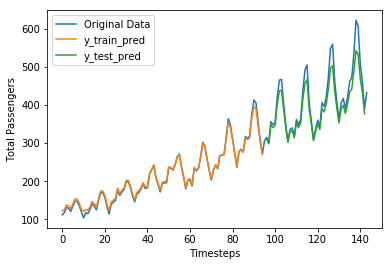

In [26]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred
# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')
plt.show()

In [27]:
train_writer.close()
test_writer.close()

In [28]:
x = np.array([[1,2],[3,4],[5,6],[7,8],[9,0],[10,11]])